# 📊 Análise de Carteira de Investimentos

Este notebook tem como objetivo analisar o comportamento de uma carteira de ações em relação a variáveis macroeconômicas (Selic, IPCA e Dólar) e, posteriormente, utilizar a Teoria Moderna de Portfólios (Markowitz) para identificar a melhor proporção de alocação entre os ativos, equilibrando retorno esperado e risco (volatilidade).

In [67]:
!pip install python-bcb
!pip install mplcyberpunk

In [68]:
# Análise Descritiva
import yfinance as yf
import numpy as np
import pandas as pd
import requests
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from bcb import sgs, currency

#Otimização Markowitz
import mplcyberpunk
import datetime as dt
import scipy.optimize as minimize
import matplotlib.ticker as mticker
from IPython.display import display
from tqdm import tqdm
from sklearn.covariance import LedoitWolf

In [69]:
# -----------------------------------
# 1) LISTA DE AÇÕES BRASILEIRAS
# -----------------------------------

# tickers = ["VALE3.SA", "PETR4.SA", "BBSE3.SA", "CMIG4.SA", "SNAG11.SA", "ITUB3.SA","SAPR4.SA","CPFE3.SA", "ELET11.SA" ]
tickers = ["VALE3.SA", "PETR4.SA", "BBSE3.SA", "CMIG4.SA", "SNAG11.SA",'FLRY3.SA','^BVSP']
peso = [0.15, 0.15, 0.1, 0.05, 0.46, 0.09]

# -----------------------------------
# 2) FUNÇÃO PARA PEGAR HISTÓRICO DE COTAÇÕES
# -----------------------------------

def get_price_history(ticker, start="2024-01-01", end=None):
    if not end:
        end = datetime.today().strftime("%Y-%m-%d")
    asset = yf.Ticker(ticker)
    df = asset.history(start=start, end=end)
    df = df[["Close"]].rename(columns={"Close": ticker})
    return df

# 2.1 Função de captação de dividendos das ações
def get_dividend_history(ticker, start="2024-01-01", end=None):
    if not end:
        end = datetime.today().strftime("%Y-%m-%d")
    asset = yf.Ticker(ticker)
    df = asset.history(start=start, end=end)
    df = df[["Dividends"]].rename(columns={"Dividends": f'{ticker}_div'})
    return df


# -----------------------------------
# 3) FUNÇÃO PARA PEGAR DADOS FINANCEIROS
#    (inclui lucro líquido, indicadores)
# -----------------------------------

def get_financials(ticker):
    asset = yf.Ticker(ticker)
    try:
        df_fin = asset.financials.transpose()
        df_bal = asset.balance_sheet.transpose()
        df_ratios = asset.info

        # Selecionando campos importantes
        data = {
            "Net Income": df_fin.get("Net Income", None),
            "Total Revenue": df_fin.get("Total Revenue", None),
            "Gross Profit": df_fin.get("Gross Profit", None),
            "Return on Equity": df_ratios.get("returnOnEquity", None),
            "PE Ratio": df_ratios.get("trailingPE", None),
            "Market Cap": df_ratios.get("marketCap", None),
        }
    except Exception as e:
        print(f"Erro em {ticker}: {e}")
        data = {}

    return pd.DataFrame([data], index=[ticker])



# -----------------------------------
# 4) BUSCAR DADOS MACRO ECONOMICOS (Ex.: DÓLAR, SELIC, IPCA)
#    Usamos APIs públicas – exemplo de dólar comercial
# -----------------------------------

def get_dolar_rate():
  #Informação da cripto ou qualquer tipo de moeda;
  coin = "BRL=X"
  start = '2024-01-01'
  end = '2026-02-13'

# Informação de btc
  dolar_real = yf.download(coin, start = start , end = end)

  dolar_real_close = dolar_real['Close'].reset_index()
  dolar_real_volume = dolar_real['Volume'].reset_index()

  return dolar_real_close


# -----------------------------------
# MARKOWITZ - OTIMIZAÇÃO DE CARTEIRA
# -----------------------------------


def mostrar_top_carteiras(vetor_ordenacao, vetor_retornos_esperados, tabela_pesos, tickers, top_n = 10, nome_ordenacao = 'Indice'):

  #Converter Log-Retorno em retorno artmetico anual
  retornos_anuais_aritmeticos = np.exp(vetor_retornos_esperados) - 1

  #Ordena o indices (maior para menor)
  indices_ordenados = np.argsort(vetor_ordenacao)[::-1]

  #Tabela de retorno e peso
  dados_tabela = []

  for i in indices_ordenados[: top_n]:
    linha = {
        'Retorno Esperado(%)': f'{retornos_anuais_aritmeticos[i] * 100:.2f}',
        nome_ordenacao: f'{vetor_ordenacao[i]:.4f}'
    }

    for j, ticker in enumerate(tickers):
      linha[ticker] = f'{tabela_pesos[i, j] *100:.2f}%'

    dados_tabela.append(linha)

  df_resultado = pd.DataFrame(dados_tabela)

  print(f"\n📋 Top {top_n} carteiras ordenadas por: {nome_ordenacao}\n")
  return df_resultado


def plot_fronteira_eficiente(volatilidades, retornos, vetor_ordenacao, titulo="Fronteira Eficiente",
                              label_ordenacao="Sharpe", cor_destaque='red', idx_vizinho=None, idx_otimo=None):
    """
    Gera o gráfico da fronteira eficiente com destaque para:
    - melhor carteira segundo a métrica fornecida
    - uma carteira "vizinha" (ex: 900ª melhor)
    """
    # Corrige: converte retornos de logarítmico para aritmético
    retornos_aritmeticos = np.exp(retornos) - 1
    retornos_pct = retornos_aritmeticos * 100
    vols_pct = volatilidades * 100

    # Para a fronteira, ordenar apenas para a linha
    indices_ordenados = np.argsort(vols_pct)
    vols_ordenados = vols_pct[indices_ordenados]
    retornos_ordenados = retornos_pct[indices_ordenados]

    fronteira_vols = []
    fronteira_rets = []
    max_ret = -np.inf
    for vol, ret in zip(vols_ordenados, retornos_ordenados):
        if ret > max_ret:
            fronteira_vols.append(vol)
            fronteira_rets.append(ret)
            max_ret = ret

    if idx_otimo is None:
        idx_otimo = vetor_ordenacao.argmax()

    plt.figure(figsize=(10, 6))
    sc = plt.scatter(vols_pct, retornos_pct, c=vetor_ordenacao, cmap='viridis', s=8, alpha=0.8)
    plt.plot(fronteira_vols, fronteira_rets, color='blue', linewidth=2, label='Fronteira eficiente')
    plt.colorbar(sc, label=label_ordenacao)

    plt.scatter(vols_pct[idx_otimo], retornos_pct[idx_otimo],
                color=cor_destaque, marker='o', s=60, label=f'Máx. {label_ordenacao}')

    if idx_vizinho is not None:
        plt.scatter(vols_pct[idx_vizinho], retornos_pct[idx_vizinho],
                    color='deepskyblue', marker='s', s=60, label=f'Carteira {idx_vizinho}')

    plt.xlabel('Volatilidade esperada')
    plt.ylabel('Retorno esperado')
    plt.title(titulo)
    plt.legend()
    plt.grid(True)

    plt.xticks(np.round(np.linspace(min(vols_pct), max(vols_pct), 6), 1),
               labels=[f'{x:.1f}%' for x in np.linspace(min(vols_pct), max(vols_pct), 6)])
    plt.yticks(np.round(np.linspace(min(retornos_pct), max(retornos_pct), 6), 1),
               labels=[f'{x:.1f}%' for x in np.linspace(min(retornos_pct), max(retornos_pct), 6)])

    plt.tight_layout()
    plt.show()


def get_commodities_close(
    start="2024-01-01",
    end=None
):
    """
    Fechamento diário absoluto das commodities:
    - Cobre
    - Minério de Ferro
    - Brent
    """

    if not end:
        end = pd.Timestamp.today().strftime("%Y-%m-%d")

    commodities = {
        'Copper': 'HG=F',
        'Iron_Ore': 'TIO=F',
        'Brent': 'BZ=F'
    }

    prices = yf.download(
        list(commodities.values()),
        start=start,
        end=end,
        auto_adjust=False,
        progress=False
    )['Close']

    prices.columns = commodities.keys()

    prices = prices.ffill()

    return prices

def plot_fronteira_eficiente_cyberpunk(volatilidades, retornos, vetor_ordenacao, titulo="Fronteira Eficiente",
                              label_ordenacao="Sharpe", cor_destaque='red', idx_vizinho=None, idx_otimo=None):

    plt.style.use("cyberpunk")

    retornos_aritmeticos = np.exp(retornos) - 1
    retornos_pct = retornos_aritmeticos * 100
    vols_pct = volatilidades * 100

    indices_ordenados = np.argsort(vols_pct)
    vols_ordenados = vols_pct[indices_ordenados]
    retornos_ordenados = retornos_pct[indices_ordenados]

    fronteira_vols = []
    fronteira_rets = []
    max_ret = -np.inf
    for vol, ret in zip(vols_ordenados, retornos_ordenados):
        if ret > max_ret:
            fronteira_vols.append(vol)
            fronteira_rets.append(ret)
            max_ret = ret

    if idx_otimo is None:
        idx_otimo = vetor_ordenacao.argmax()

    plt.figure(figsize=(10, 6))
    sc = plt.scatter(vols_pct, retornos_pct, c=vetor_ordenacao, cmap='viridis', s=8, alpha=0.8)
    plt.plot(fronteira_vols, fronteira_rets, color='cyan', linewidth=2, label='Fronteira eficiente')
    plt.colorbar(sc, label=label_ordenacao)

    plt.scatter(vols_pct[idx_otimo], retornos_pct[idx_otimo],
                color=cor_destaque, marker='o', s=60, label=f'Máx. {label_ordenacao}')

    if idx_vizinho is not None:
        plt.scatter(vols_pct[idx_vizinho], retornos_pct[idx_vizinho],
                    color='deepskyblue', marker='s', s=60, label=f'Carteira {idx_vizinho}')

    plt.xlabel('Volatilidade esperada')
    plt.ylabel('Retorno esperado')
    plt.title(titulo)
    plt.legend()
    plt.grid(True)

    plt.xticks(np.round(np.linspace(min(vols_pct), max(vols_pct), 6), 1),
               labels=[f'{x:.1f}%' for x in np.linspace(min(vols_pct), max(vols_pct), 6)])
    plt.yticks(np.round(np.linspace(min(retornos_pct), max(retornos_pct), 6), 1),
               labels=[f'{x:.1f}%' for x in np.linspace(min(retornos_pct), max(retornos_pct), 6)])

    plt.tight_layout()

    # 🔥 Aplica efeitos neon do cyberpunk
    mplcyberpunk.add_glow_effects()

    plt.show()



In [70]:
# ================================
# Coleta das séries temporais
# ================================
# Selic (diária) e IPCA (mensal) a partir de 01/01/2024
selic = sgs.get({'Selic': 432}, start='2024-01-01')
ipca  = sgs.get({'IPCA': 433}, start='2024-01-01')


# ================================
# Padronização inicial dos dados
# ================================
# Transformação do índice em coluna de data
selic.reset_index(inplace=True)
ipca.reset_index(inplace=True)


# ================================
# Criação de índice diário contínuo
# ================================
# Intervalo diário baseado no período da Selic
idx_diario = pd.date_range(
    start=selic['Date'].min(),
    end=selic['Date'].max(),
    freq='D'
)


# ================================
# Ajuste da frequência do IPCA
# ================================
# Expansão do IPCA para base diária
# Preenchimento dos valores ausentes com o último dado disponível
ipca = (
    ipca
    .set_index('Date')
    .reindex(idx_diario)
    .ffill()
    .reset_index()
)

# Renomeação da coluna de data
ipca.rename(columns={'index': 'Date'}, inplace=True)


# ================================
# Padronização final do tipo de data
# ================================
# Conversão das datas para formato date (sem horário)
selic['Date'] = pd.to_datetime(selic['Date']).dt.date
ipca['Date']  = pd.to_datetime(ipca['Date']).dt.date

In [71]:

# -----------------------------------
# 5) EXECUTAR E JUNTAR DADOS
# -----------------------------------

# Histórico de preços
price_dfs = [get_price_history(t) for t in tickers]
prices = pd.concat(price_dfs, axis=1)
print("\n📈 Histórico de Preços (close):")


# Dados fundamentalistas
funds = pd.concat([get_financials(t) for t in tickers])
print("\n📊 Dados Financeiros:")

# Dolar
dolar_real_close = get_dolar_rate()



📈 Histórico de Preços (close):


/tmp/ipython-input-271/1672668593.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  funds = pd.concat([get_financials(t) for t in tickers])
/tmp/ipython-input-271/1591778136.py:72: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dolar_real = yf.download(coin, start = start , end = end)
[*********************100%***********************]  1 of 1 completed


📊 Dados Financeiros:


In [72]:
# Histórico de preços
dividend_dfs = [get_dividend_history(t) for t in tickers]
dividend = pd.concat(dividend_dfs, axis=1)
print("\n📈 Histórico de Dividendo:")


📈 Histórico de Dividendo:


In [73]:
# ================================
# Preparação da base principal
# ================================
# Transformação do índice em coluna de data
prices.reset_index(inplace=True)

# Padronização da data (remoção de horário)
prices['Date'] = prices['Date'].dt.date


# ================================
# Padronização da base cambial
# ================================
# Conversão da data para o mesmo formato da base principal
dolar_real_close['Date'] = dolar_real_close['Date'].dt.date


# ================================
# Consolidação das bases
# ================================
# Inclusão do dólar, Selic e IPCA via merge por data
prices = prices.merge(dolar_real_close, how='left', on='Date')
prices = prices.merge(selic, how='left', on='Date')
prices = prices.merge(ipca, how='left', on='Date')


# ================================
# Ajustes finais de nomenclatura
# ================================
# Renomeação da coluna de câmbio
prices.rename(columns={'BRL=X': 'Dolar'}, inplace=True)


# ================================
# Definição do índice temporal
# ================================
# Retorno da data como índice da tabela
prices = prices.set_index('Date')

In [74]:
# ================================
# Inicialização do normalizador
# ================================
# Escalonamento dos dados para o intervalo [0, 1]
scaler = MinMaxScaler()


# ================================
# Seleção das variáveis numéricas
# ================================
# Identificação automática das colunas numéricas
columns = prices.select_dtypes(include='number').columns


# ================================
# Normalização da base de preços
# ================================
# Cópia da base original para preservação dos dados brutos
prices_norm = prices.copy()

# Aplicação do Min-Max Scaling apenas nas colunas numéricas
prices_norm[columns] = scaler.fit_transform(prices[columns])


# ================================
# Base final de ativos
# ================================
# Definição da base normalizada para análises posteriores
assets = prices_norm.copy()

<Axes: xlabel='Date'>

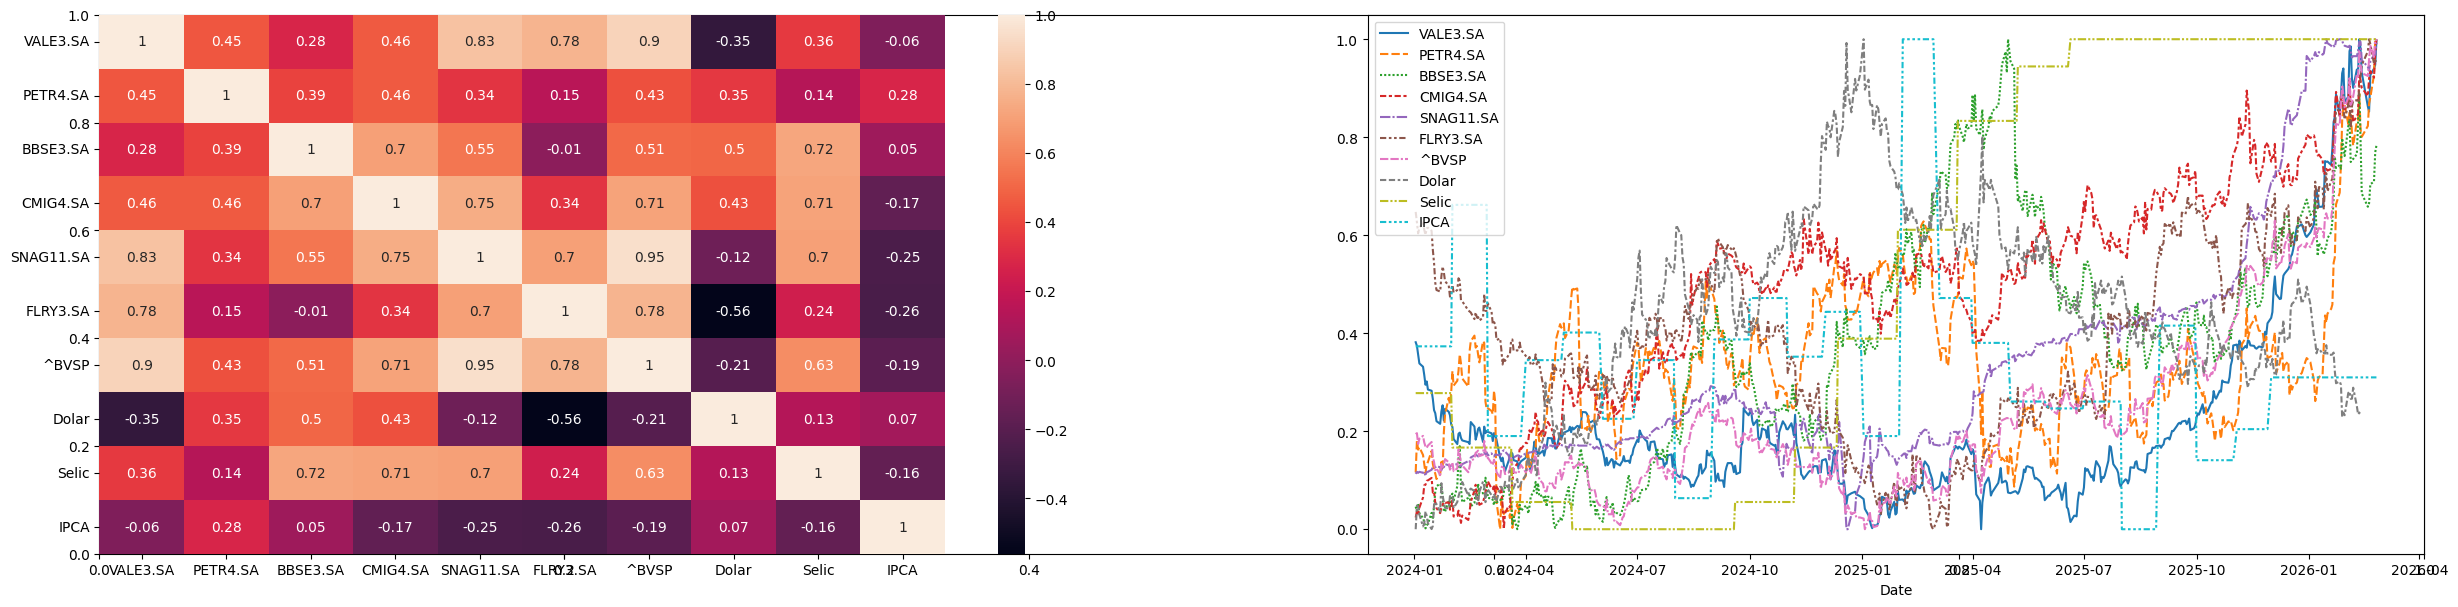

In [75]:
plt.subplots(figsize = (30, 7))

#Matriz de Correlação
plt.subplot(1,2,1)
sns.heatmap(assets.corr().round(2), annot = True)

#Historico de fechamento das ações selecionadas
plt.subplot(1,2,2)
sns.lineplot(assets)


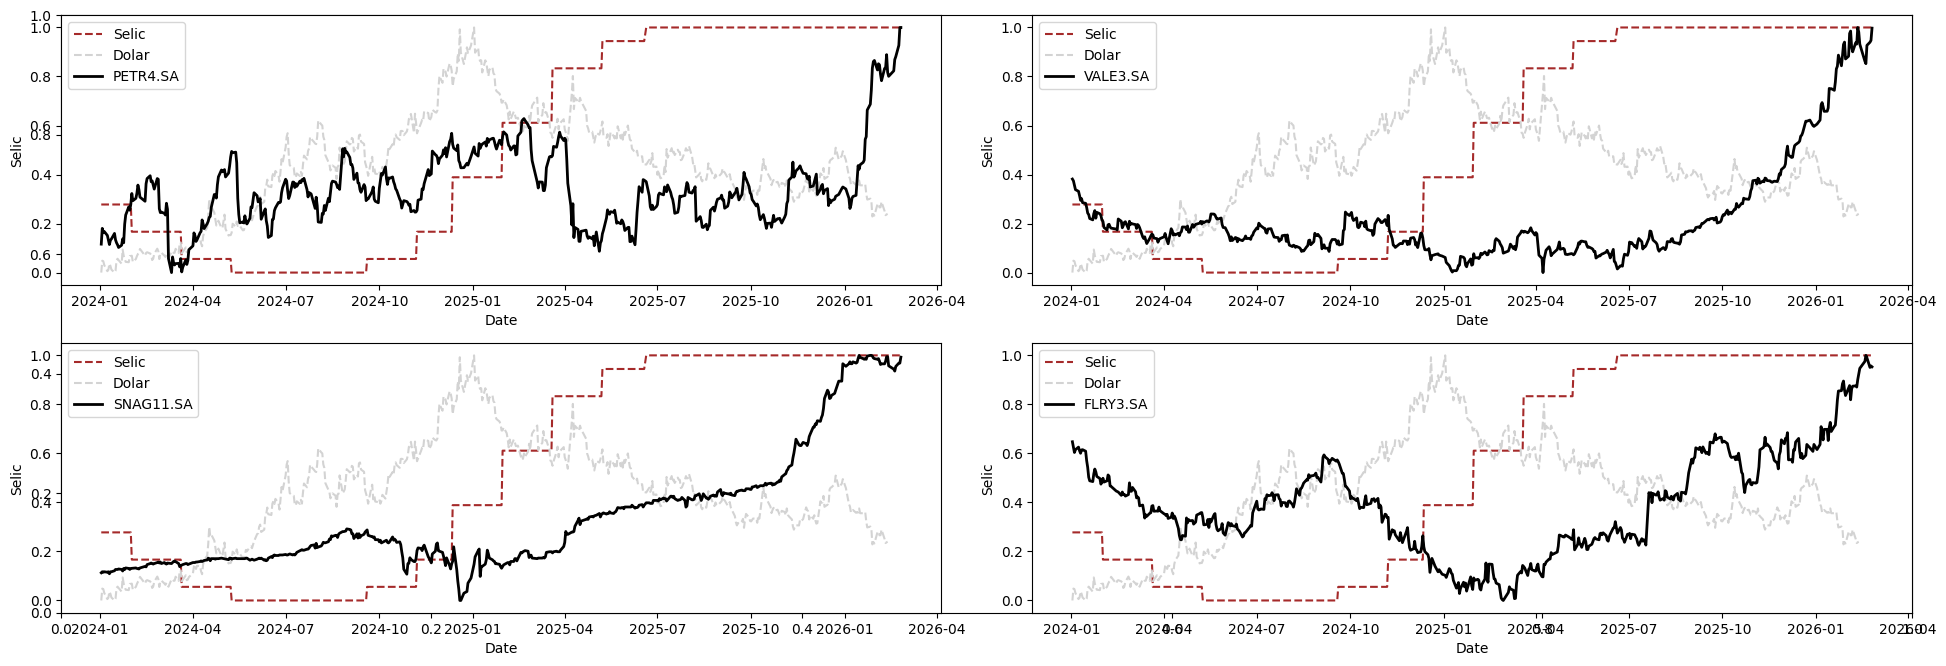

In [76]:
# ================================
# Configuração da área do gráfico
# ================================
# Definição do tamanho total da figura
plt.subplots(figsize=(20, 7))


# ================================
# Ativo: PETR4.SA
# ================================
# Comparação do ativo com Selic e Dólar
plt.subplot(2, 2, 1)
ax1 = plt.gca()

sns.lineplot(data=assets['Selic'], ax=ax1, linestyle='--', color='brown', label='Selic')
sns.lineplot(data=assets['Dolar'], ax=ax1, linestyle='--', color='lightgrey', label='Dolar')
sns.lineplot(data=assets['PETR4.SA'], ax=ax1, linestyle='-', color='black', linewidth=2, label='PETR4.SA')

ax1.legend()


# ================================
# Ativo: VALE3.SA
# ================================
# Comparação do ativo com Selic e Dólar
plt.subplot(2, 2, 2)
ax2 = plt.gca()

sns.lineplot(data=assets['Selic'], ax=ax2, linestyle='--', color='brown', label='Selic')
sns.lineplot(data=assets['Dolar'], ax=ax2, linestyle='--', color='lightgrey', label='Dolar')
sns.lineplot(data=assets['VALE3.SA'], ax=ax2, linestyle='-', color='black', linewidth=2, label='VALE3.SA')

ax2.legend()


# ================================
# Ativo: SNAG11.SA
# ================================
# Comparação do ativo com Selic e Dólar
plt.subplot(2, 2, 3)
ax3 = plt.gca()

sns.lineplot(data=assets['Selic'], ax=ax3, linestyle='--', color='brown', label='Selic')
sns.lineplot(data=assets['Dolar'], ax=ax3, linestyle='--', color='lightgrey', label='Dolar')
sns.lineplot(data=assets['SNAG11.SA'], ax=ax3, linestyle='-', color='black', linewidth=2, label='SNAG11.SA')

ax3.legend()


# ================================
# Ativo: FLRY3.SA
# ================================
# Comparação do ativo com Selic e Dólar
plt.subplot(2, 2, 4)
ax4 = plt.gca()

sns.lineplot(data=assets['Selic'], ax=ax4, linestyle='--', color='brown', label='Selic')
sns.lineplot(data=assets['Dolar'], ax=ax4, linestyle='--', color='lightgrey', label='Dolar')
sns.lineplot(data=assets['FLRY3.SA'], ax=ax4, linestyle='-', color='black', linewidth=2, label='FLRY3.SA')

ax4.legend()


# ================================
# Ajustes finais
# ================================
# Organização automática dos subplots
plt.tight_layout()

# Exibição do gráfico
plt.show()

### Analise de Commodites + Ações (PETR4.SA / VALE3.SA)

In [77]:
tickers_com = ['VALE3.SA','PETR4.SA']


# Histórico de preços
price_dfs_1 = [get_price_history(t) for t in tickers_com]
prices_1 = pd.concat(price_dfs_1, axis=1)
print("\n📈 Histórico de Preços (close):")


# Dados fundamentalistas
funds_1= pd.concat([get_financials(t) for t in tickers_com])
print("\n📊 Dados Financeiros:")

# Dolar
dolar_real_close = get_dolar_rate()

#Commodites
comodite = get_commodities_close()


#Date - Index
prices_1.index = pd.to_datetime(prices.index).tz_localize(None).normalize()

#Merge de indices
prices_1 = prices_1.merge(dolar_real_close, how = 'left', on = 'Date').merge(comodite, how = 'left', on = 'Date')
prices_1.rename(columns = {'BRL=X': 'Dolar'}, inplace = True)




📈 Histórico de Preços (close):


/tmp/ipython-input-271/1591778136.py:72: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dolar_real = yf.download(coin, start = start , end = end)
[*********************100%***********************]  1 of 1 completed


📊 Dados Financeiros:


In [78]:
# ================================
# Inicialização do normalizador
# ================================
# Escalonamento dos dados para o intervalo [0, 1]
scaler = MinMaxScaler()


# ================================
# Seleção das variáveis numéricas
# ================================
# Identificação automática das colunas numéricas
columns = prices_1.select_dtypes(include='number').columns


# ================================
# Normalização da base de preços
# ================================
# Cópia da base original para preservação dos dados brutos
prices_1_norm = prices_1.copy()

# Aplicação do Min-Max Scaling apenas nas colunas numéricas
prices_1_norm[columns] = scaler.fit_transform(prices_1[columns])


# ================================
# Base final de ativos
# ================================
# Definição da base normalizada para análises posteriores
assets_com = prices_1_norm.copy()
assets_1 = prices_1

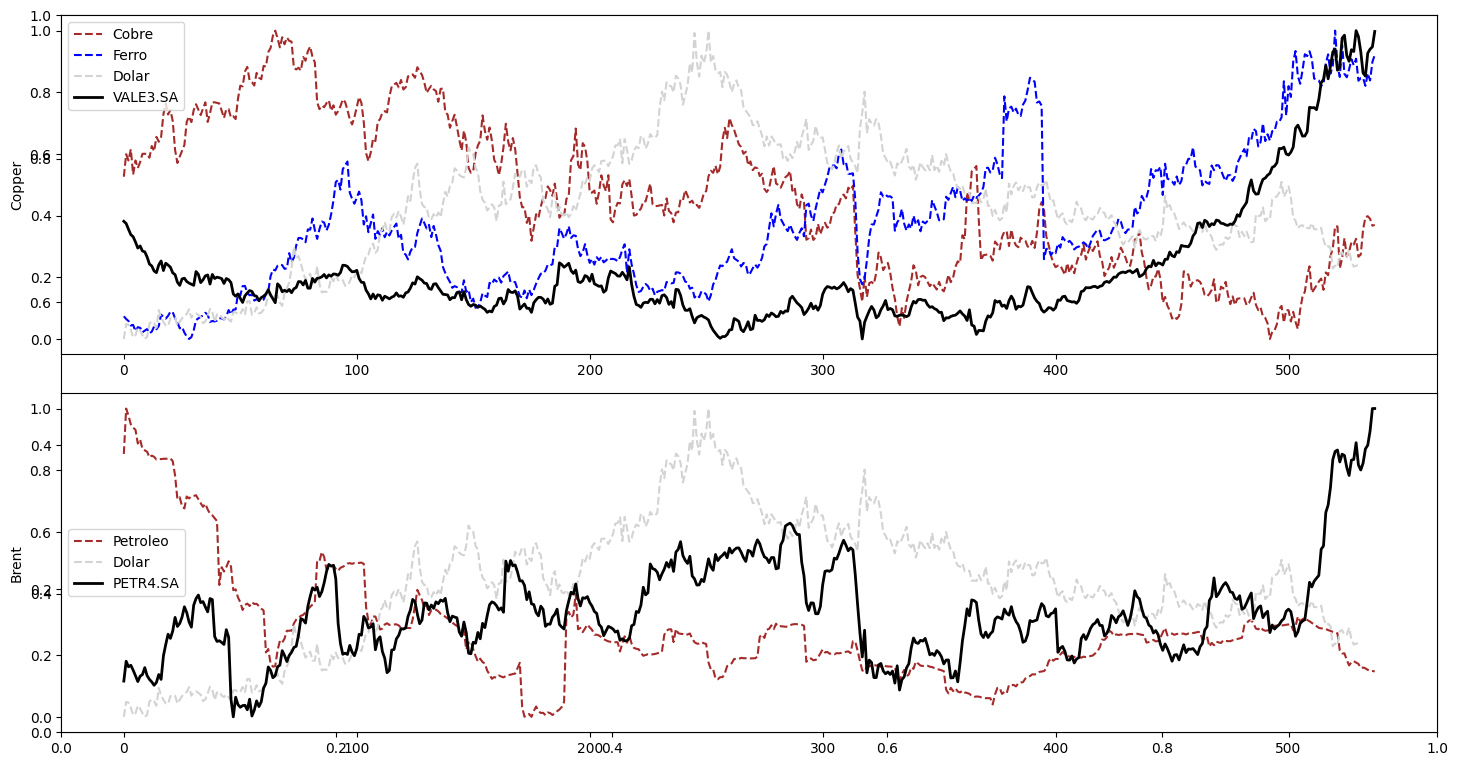

In [79]:
# ================================
# Configuração da área do gráfico
# ================================
# Definição do tamanho total da figura
plt.subplots(figsize=(15, 8))


# ================================
# Ativo: VALE3.SA
# ================================
plt.subplot(2,1,1)
# Comparação do ativo com Selic e Dólar
ax1 = plt.gca()

sns.lineplot(data=assets_com['Copper'], ax=ax1, linestyle='--', color='brown', label='Cobre')
sns.lineplot(data=assets_com['Iron_Ore'], ax=ax1, linestyle='--', color='blue', label='Ferro')
sns.lineplot(data=assets_com['Dolar'], ax=ax1, linestyle='--', color='lightgrey', label='Dolar')
sns.lineplot(data=assets_com['VALE3.SA'], ax=ax1, linestyle='-', color='black', linewidth=2, label='VALE3.SA')

ax1.legend()



# ================================
# Ativo: VALE3.SA
# ================================
# Comparação do ativo com Selic e Dólar
plt.subplot(2,1,2)
ax2 = plt.gca()

sns.lineplot(data=assets_com['Brent'], ax=ax2, linestyle='--', color='brown', label='Petroleo')
sns.lineplot(data=assets_com['Dolar'], ax=ax2, linestyle='--', color='lightgrey', label='Dolar')
sns.lineplot(data=assets_com['PETR4.SA'], ax=ax2, linestyle='-', color='black', linewidth=2, label='PETR4.SA')

ax2.legend()


# ================================
# Ajustes finais
# ================================
# Organização automática dos subplots
plt.tight_layout()

# Exibição do gráfico
plt.show()

<Axes: title={'center': 'VALE / PETROBRAS'}, xlabel='Date', ylabel='PETR4.SA'>

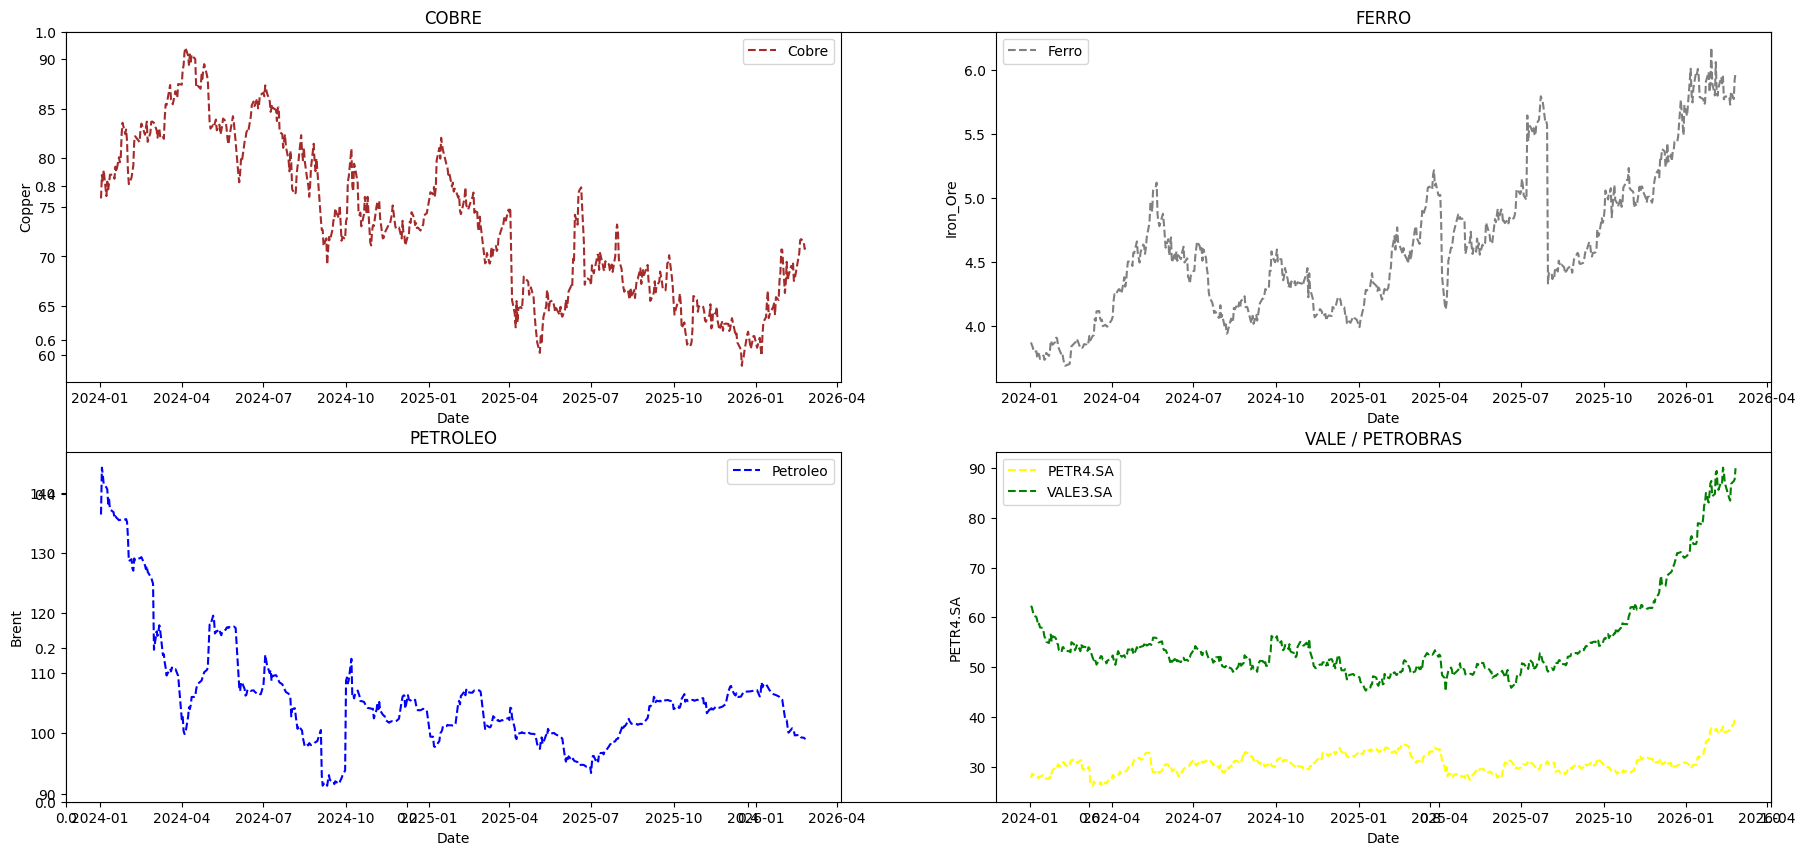

In [104]:
# Definição do tamanho total da figura
plt.subplots(figsize=(22, 10))

plt.subplot(2,2,1)
ax1 = plt.gca()

sns.lineplot(data=assets_1[['Date','Copper']],x = 'Date',y = 'Copper', ax=ax1, linestyle='--', color='brown', label='Cobre')
plt.title('COBRE')

plt.subplot(2,2,2)
ax2 = plt.gca()

sns.lineplot(data=assets_1[['Date','Iron_Ore']],x = 'Date',y = 'Iron_Ore', ax=ax2, linestyle='--', color='grey', label='Ferro')
plt.title('FERRO')


plt.subplot(2,2,3)
ax3 = plt.gca()

sns.lineplot(data=assets_1[['Date','Brent']],x = 'Date',y = 'Brent', ax=ax3, linestyle='--', color='blue', label='Petroleo')
plt.title('PETROLEO')


plt.subplot(2,2,4)
ax4 = plt.gca()
plt.title('VALE / PETROBRAS')
sns.lineplot(data=assets_1,x='Date',y='PETR4.SA',ax=ax4,color= 'yellow',linestyle='--',label='PETR4.SA')
sns.lineplot(data=assets_1,x='Date',y='VALE3.SA',ax=ax4,linestyle='--',color ='green',label='VALE3.SA')

## Mensalizando resultados de ações + dividendos

In [81]:
# ================================
# Preparação da base
# ================================
# Transformação do índice em coluna
prices.reset_index(inplace=True)


# ================================
# Identificação do mês de referência
# ================================
# Criação da coluna mês-ano para agrupamento
prices['Month'] = pd.to_datetime(prices['Date']).dt.to_period('M')


# ================================
# Filtragem das segundas-feiras
# ================================
# Seleção apenas das observações que caem em segunda-feira
mondays = prices[pd.to_datetime(prices['Date']).dt.weekday == 0]


# ================================
# Primeira segunda-feira do mês
# ================================
# Identificação da primeira segunda-feira de cada mês
first_monday = (
    mondays
    .sort_values('Date')
    .groupby('Month', as_index=False)
    .first()
)


# ================================
# Ajuste de formato do mês
# ================================
# Conversão do período para string
first_monday['Month'] = first_monday['Month'].astype(str)


# ================================
# Base de preços iniciais do mês
# ================================
# Remoção de colunas macroeconômicas e data
price_init_month = first_monday.drop(
    columns=['Date', 'Selic', 'IPCA', 'Dolar']
)

In [82]:
#Identificação de variação de ações por mês (2024-2026)
diff_assets = price_init_month.set_index('Month')[tickers].diff()

print('%MoM Assets')
display(diff_assets.head())

%MoM Assets


VALE3.SA  PETR4.SA  BBSE3.SA  CMIG4.SA  SNAG11.SA  FLRY3.SA   ^BVSP
Month                                                                       
2024-01       NaN       NaN       NaN       NaN        NaN       NaN     NaN
2024-02 -7.084206  2.037113  0.791872 -0.221920   0.065066 -1.115844 -4834.0
2024-03  0.986618 -0.828033 -0.300747  0.327041   0.081356 -0.363494   748.0
2024-04 -2.241333 -1.780642 -0.183533  0.549671   0.000000 -0.729361 -1351.0
2024-05  2.500832  3.993078  0.462830  0.671061   0.042736  0.008537  1476.0

----- Média de Variação de Ação por Mês ao longo do período analisado (2024 - 02/2026) -----
VALE3.SA        0.990315
PETR4.SA        0.363182
BBSE3.SA        0.388546
CMIG4.SA        0.189520
SNAG11.SA       0.128270
FLRY3.SA        0.078331
^BVSP        2014.640000
dtype: float64
----- Desvio Padrão de Ação por Mês ao longo do período analisado (2024 - 02/2026) -----
VALE3.SA        4.033845
PETR4.SA        2.335884
BBSE3.SA        1.618039
CMIG4.SA        0.481687
SNAG11.SA       0.258986
FLRY3.SA        0.858238
^BVSP        6231.554487
dtype: float64


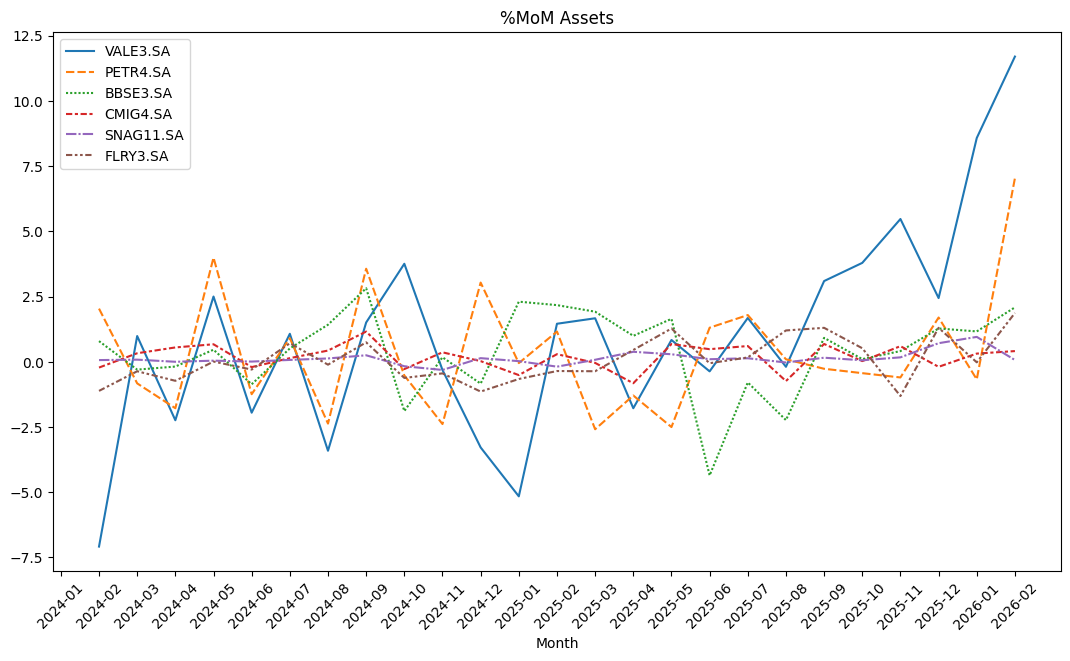

In [83]:
# ================================
# Visualização das variações mensais
# ================================
# Definição do tamanho do gráfico
plt.subplots(figsize=(13, 7))

# Plot das variações mensais dos ativos (excluindo o índice de mercado)
sns.lineplot(
    diff_assets.drop(columns='^BVSP')
)

# Ajuste da rotação dos rótulos do eixo x
plt.xticks(rotation=45)

#Titulo
plt.title('%MoM Assets')


# ================================
# Estatísticas descritivas
# ================================
# Média da variação mensal por ativo no período analisado
print('----- Média de Variação de Ação por Mês ao longo do período analisado (2024 - 02/2026) -----')
print(diff_assets.mean())


# Desvio padrão da variação mensal por ativo no período analisado
print('----- Desvio Padrão de Ação por Mês ao longo do período analisado (2024 - 02/2026) -----')
print(diff_assets.std())

In [84]:
# ================================
# Preparação da base para análise anual
# ================================
# Transformação do índice em coluna
diff_assets.reset_index(inplace=True)


# ================================
# Extração do ano
# ================================
# Criação da coluna de ano a partir do mês
diff_assets['Year'] = pd.to_datetime(diff_assets['Month']).dt.year


# ================================
# Variação média anual dos ativos
# ================================
# Cálculo da média das variações por ativo em cada ano
diff_assets.groupby('Year')[tickers].mean()

VALE3.SA  PETR4.SA  BBSE3.SA  CMIG4.SA  SNAG11.SA  FLRY3.SA  \
Year                                                                 
2024  -0.769421  0.400508  0.191404  0.268806   0.027266 -0.305764   
2025   1.078558 -0.140927  0.363151  0.088109   0.157130  0.289436   
2026  10.139404  3.182545  1.625193  0.361911   0.510635  0.924225   

             ^BVSP  
Year                
2024   -653.727273  
2025   2781.250000  
2026  12091.000000

In [85]:
# ================================
# Limpeza da base de variações
# ================================
# Remoção da coluna de ano após uso na análise
diff_assets.drop(columns='Year', inplace=True)


# ================================
# Definição dos ativos com dividendos
# ================================
# Lista de colunas referentes aos dividendos por ativo
assets_yield = [
    'VALE3.SA_div',
    'PETR4.SA_div',
    'BBSE3.SA_div',
    'CMIG4.SA_div',
    'SNAG11.SA_div',
    'FLRY3.SA_div'
]


# ================================
# Preparação da base de dividendos
# ================================
# Transformação do índice em coluna
dividend = dividend.reset_index()

# Criação da coluna mês-ano para agregação mensal
dividend['Month'] = dividend['Date'].dt.strftime('%Y-%m')

# Remoção da coluna de data diária
dividend.drop(columns='Date', inplace=True)


# ================================
# Consolidação mensal de dividendos
# ================================
# Soma dos dividendos por ativo em cada mês
dividend_month = (
    dividend
    .groupby('Month')[assets_yield]
    .sum()
    .reset_index()
)
# ================================
# Total de dividendos no período
# ================================
# Soma total de dividendos por ativo (equivalente a 1 ano no período analisado)
print('1 Ano de dividendo por ação \n')
print(dividend[assets_yield].sum())

1 Ano de dividendo por ação 

VALE3.SA_div     12.971882
PETR4.SA_div     11.212470
BBSE3.SA_div      9.506933
CMIG4.SA_div      2.979603
SNAG11.SA_div     2.935000
FLRY3.SA_div      2.374209
dtype: float64


In [86]:
display(dividend_month)

Month  VALE3.SA_div  PETR4.SA_div  BBSE3.SA_div  CMIG4.SA_div  \
0   2024-01      0.000000      0.000000      0.000000      0.000000   
1   2024-02      0.000000      0.000000      1.261289      0.000000   
2   2024-03      2.738548      0.000000      0.000000      0.135051   
3   2024-04      0.000000      1.150024      0.000000      0.186360   
4   2024-05      0.000000      1.776022      0.000000      0.000000   
5   2024-06      0.000000      1.043242      0.000000      0.150212   
6   2024-07      0.000000      0.000000      0.000000      0.000000   
7   2024-08      2.093798      1.053200      1.390909      0.496360   
8   2024-09      0.000000      0.000000      0.000000      0.165202   
9   2024-10      0.000000      0.000000      0.000000      0.000000   
10  2024-11      0.000000      0.000000      0.000000      0.000000   
11  2024-12      0.520531      2.908634      0.000000      0.195808   
12  2025-01      0.000000      0.000000      0.000000      0.000000   
13  2025-02      0.000000      0.000000      2.320161      0.000000   
14  2025-03      2.141847      0.000000      0.000000      0.189118   
15  2025-04      0.000000      0.748130      0.000000      0.000000   
16  2025-05      0.000000      0.000000      0.000000      0.658812   
17  2025-06      0.000000      0.909166      0.000000      0.208607   
18  2025-07      0.000000      0.000000      0.000000      0.000000   
19  2025-08      1.895387      0.671924      1.942095      0.000000   
20  2025-09      0.000000      0.000000      0.000000      0.211396   
21  2025-10      0.000000      0.000000      0.000000      0.000000   
22  2025-11      0.000000      0.000000      0.000000      0.000000   
23  2025-12      3.581771      0.952128      0.000000      0.382677   
24  2026-01      0.000000      0.000000      0.000000      0.000000   
25  2026-02      0.000000      0.000000      2.592479      0.000000   

    SNAG11.SA_div  FLRY3.SA_div  
0           0.105      0.000000  
1           0.105      0.000000  
2           0.105      0.147614  
3           0.105      0.000000  
4           0.105      0.000000  
5           0.100      0.000000  
6           0.100      0.000000  
7           0.100      0.337384  
8           0.100      0.000000  
9           0.100      0.000000  
10          0.100      0.000000  
11          0.100      0.213913  
12          0.110      0.000000  
13          0.110      0.000000  
14          0.110      0.466140  
15          0.110      0.000000  
16          0.110      0.000000  
17          0.110      0.000000  
18          0.110      0.000000  
19          0.110      0.310099  
20          0.120      0.000000  
21          0.120      0.000000  
22          0.130      0.000000  
23          0.130      0.899059  
24          0.130      0.000000  
25          0.200      0.000000

## Beta

In [87]:
# ================================
# Preparação da base para regressão
# ================================
# Remoção de observações com valores ausentes
analyse = diff_assets.dropna()


# ================================
# Regressão linear por ativo
# ================================
# Estimativa do beta em relação ao índice de mercado
for i in tickers:

    # Variável dependente (retorno do ativo)
    Y = analyse[i]

    # Variável independente (retorno do benchmark)
    X = analyse['^BVSP']

    # Inclusão do termo constante no modelo
    X = sm.add_constant(X)

    # Ajuste do modelo de regressão linear
    model = sm.OLS(Y, X).fit()

    # ================================
    # Extração das métricas do modelo
    # ================================
    print(i)
    print(f'Beta = {model.params.iloc[1]}')
    print(f'R Quadrado = {model.rsquared}')
    print('-----------------------')

    # Sumário completo do modelo (opcional)
    # print(model.summary())

VALE3.SA
Beta = 0.0004655925320601057
R Quadrado = 0.5173285830203628
-----------------------
PETR4.SA
Beta = 0.00017408415906732086
R Quadrado = 0.2156795283403976
-----------------------
BBSE3.SA
Beta = 0.00010814602784304234
R Quadrado = 0.17347454427505993
-----------------------
CMIG4.SA
Beta = 4.301764360791057e-05
R Quadrado = 0.3097104357115176
-----------------------
SNAG11.SA
Beta = 1.2154819431837359e-05
R Quadrado = 0.08553359133298333
-----------------------
FLRY3.SA
Beta = 8.493930016701625e-05
R Quadrado = 0.3803602809611586
-----------------------
^BVSP
Beta = 1.0000000000000002
R Quadrado = 1.0
-----------------------


# Otimização de Markowitz


## Retorno logarítmico da ação

Utilizamos o **retorno logarítmico** como métrica principal de variação das ações, pois ele permite  
**acumular retornos ao longo do tempo de forma consistente e sem viés**.

Diferentemente do retorno simples, o retorno logarítmico preserva a proporcionalidade das variações e é  
**aditivo no tempo**, o que o torna especialmente adequado para análises de múltiplos períodos,  
comparação entre ativos e construção de portfólios.

Essa abordagem garante uma **representação mais fiel do desempenho real da ação**, sobretudo em  
cenários de maior volatilidade.

---

### Exemplo comparativo

**Retorno simples (não logarítmico)**  
- Dia 1: **+10%**  
- Dia 2: **−10%**  
- **Resultado final:** **0%**

> Apesar da variação parecer neutra, o capital **não retorna ao valor inicial**.

---

**Retorno logarítmico**  
- Dia 1: **+10%** → 100 → **110**  
- Dia 2: **−10%** → 110 → **99**  
- **Resultado final:** **−1%**

> O retorno logarítmico captura corretamente a **perda acumulada**, refletindo o efeito real das  
> variações percentuais sucessivas.

---

Em resumo, o uso do retorno logarítmico:

- Elimina **distorções matemáticas**  
- Permite **soma consistente dos retornos no tempo**  
- Oferece uma base **estatística mais robusta**  
- É ideal para análises de **risco, retorno esperado e otimização de carteiras**

In [88]:

start_date = '2024-01-01'
end_date = '2026-02-13'

#Ações de analise;
tickers_sharpe = tickers[:-1]

#Download das ações propostas;
df = yf.download(tickers_sharpe, start = start_date, end = end_date)['Close']

#Construção dos retornos logaritmicos, propondo haver a soma da variação mais fidedigno ao ganho final
returns = df.pct_change().apply(lambda x: np.log(1+x)).dropna() # Retorno logarítimo
returns_mean = returns.mean() # Media dos retornos diários
matrix_cov = returns.cov() # Matriz de covariância dos retornos diários

print("Média dos Retornos Diários:")
print(returns_mean.sort_values(ascending = False))

print("\nMatriz de Covariância dos Retornos Diários:")
print(matrix_cov)

/tmp/ipython-input-271/1430737505.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers_sharpe, start = start_date, end = end_date)['Close']
[*********************100%***********************]  6 of 6 completed

Média dos Retornos Diários:
Ticker
CMIG4.SA     0.001098
VALE3.SA     0.000678
SNAG11.SA    0.000668
BBSE3.SA     0.000566
PETR4.SA     0.000553
FLRY3.SA     0.000262
dtype: float64

Matriz de Covariância dos Retornos Diários:
Ticker     BBSE3.SA  CMIG4.SA  FLRY3.SA  PETR4.SA  SNAG11.SA  VALE3.SA
Ticker                                                                
BBSE3.SA   0.000120  0.000046  0.000040  0.000013   0.000003  0.000019
CMIG4.SA   0.000046  0.000223  0.000077  0.000038   0.000005  0.000039
FLRY3.SA   0.000040  0.000077  0.000272  0.000038   0.000008  0.000055
PETR4.SA   0.000013  0.000038  0.000038  0.000232   0.000006  0.000050
SNAG11.SA  0.000003  0.000005  0.000008  0.000006   0.000039  0.000003
VALE3.SA   0.000019  0.000039  0.000055  0.000050   0.000003  0.000216



/tmp/ipython-input-271/1430737505.py:11: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = df.pct_change().apply(lambda x: np.log(1+x)).dropna() # Retorno logarítimo


In [89]:
numero_carteira = 100000
vetor_retornos_esperados = np.zeros(numero_carteira)
vetor_volatilidades_esperadas = np.zeros(numero_carteira)

vetor_sharpe = np.zeros(numero_carteira)
tabela_pesos = np.zeros((numero_carteira, len(tickers[:-1])))


for k in tqdm(range(numero_carteira), desc = 'Simulando Carteiras'):
  pesos = np.random.random(len(tickers[:-1])) #Pesos aleatorios
  pesos = pesos / np.sum(pesos) #Normaliza os pesos para que a soam seja 1

  tabela_pesos[k,:]  = pesos #Adiciona o peso na tabela de pesos

  #Calculo do retorno esperado e a volatilidade esperada da carteira
  vetor_retornos_esperados[k] = np.sum(returns_mean * pesos) * 252 #Retorno esperado anualizado;

  #Calculo da volatilidade esperada na carteira;
  vetor_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matrix_cov * 252, pesos))) #Volatilidade esperada anualizada

  # Calcula o índice de Sharpe (assumindo taxa livre de risco de 0%)
  vetor_sharpe[k] = vetor_retornos_esperados[k] / vetor_volatilidades_esperadas[k]

Simulando Carteiras: 100%|██████████| 100000/100000 [00:31<00:00, 3223.91it/s]


In [90]:
np.set_printoptions(suppress= True) #Desativação da notação cientifica

# ===============================
# 🟢 Carteira com Sharpe Máximo (sem penalização)
# ===============================

max_sharpe_index = vetor_sharpe.argmax()  # Índice da carteira com maior índice de Sharpe
melhor_carteira = tabela_pesos[max_sharpe_index, :]  # Pesos da carteira ótima

print("\n\n🔝 Carteira com maior Índice de Sharpe (retorno máximo por risco):\n")

tabela_resultados = pd.DataFrame({
    'Ticker': tickers_sharpe,
    'Peso (%)': [f'{peso*100:.2f}%' for peso in melhor_carteira]
})
print(tabela_resultados)

# Retorno esperado aritmético (usando log-retornos)
tabela_retornos_esperados_aritmetica = np.exp(vetor_retornos_esperados) - 1

print(f'\n📈 Retorno esperado (1 ano): {tabela_retornos_esperados_aritmetica[max_sharpe_index]*100:.2f}%')
print(f"📊 Índice de Sharpe: {vetor_sharpe[max_sharpe_index]:.4f}")

# ===============================
# 🔍 Carteira "vizinha" — próxima ao topo, mas com pesos diferentes
# ===============================

VIZINHO_N = 5

print("\n-----------------------------------------------------------------------------------------------------------")
print(f'\n🔄 Carteira {VIZINHO_N} da Vizinhança do Maior Índice de Sharpe:')

# Pega a 900ª melhor carteira no Sharpe tradicional
indices_ordenados = np.argsort(vetor_sharpe)
vizinhanca_max_sharpe_index = indices_ordenados[-(VIZINHO_N+1)]  # Índice da carteira vizinha
vizinhanca_carteira = tabela_pesos[vizinhanca_max_sharpe_index, :]

tabela_resultados_vizinha = pd.DataFrame({
    'Ticker': tickers_sharpe,
    'Peso (%)': [f'{peso*100:.2f}%' for peso in vizinhanca_carteira]
})
print(tabela_resultados_vizinha)

print(f'\n📈 Retorno esperado (1 ano): {tabela_retornos_esperados_aritmetica[vizinhanca_max_sharpe_index]*100:.2f}%')
print(f"📊 Índice de Sharpe: {vetor_sharpe[vizinhanca_max_sharpe_index]:.4f}")

# ===============================
# 🧮 Top carteiras por Sharpe (tabela completa)
# ===============================

print("\n-----------------------------------------------------------------------------------------------------------")
df_top_sharpe = mostrar_top_carteiras(
    vetor_ordenacao=vetor_sharpe,
    vetor_retornos_esperados=vetor_retornos_esperados,
    tabela_pesos=tabela_pesos,
    tickers=tickers_sharpe,
    top_n=2000,
    nome_ordenacao="Sharpe"
)

display(df_top_sharpe)



🔝 Carteira com maior Índice de Sharpe (retorno máximo por risco):

      Ticker Peso (%)
0   VALE3.SA   16.22%
1   PETR4.SA   16.66%
2   BBSE3.SA    0.77%
3   CMIG4.SA    6.45%
4  SNAG11.SA   54.58%
5   FLRY3.SA    5.32%

📈 Retorno esperado (1 ano): 19.68%
📊 Índice de Sharpe: 2.0699

-----------------------------------------------------------------------------------------------------------

🔄 Carteira 5 da Vizinhança do Maior Índice de Sharpe:
      Ticker Peso (%)
0   VALE3.SA   15.26%
1   PETR4.SA   19.44%
2   BBSE3.SA    2.60%
3   CMIG4.SA    2.43%
4  SNAG11.SA   51.45%
5   FLRY3.SA    8.81%

📈 Retorno esperado (1 ano): 19.99%
📊 Índice de Sharpe: 2.0221

-----------------------------------------------------------------------------------------------------------

📋 Top 2000 carteiras ordenadas por: Sharpe



Retorno Esperado(%)  Sharpe VALE3.SA PETR4.SA BBSE3.SA CMIG4.SA  \
0                  19.68  2.0699   16.22%   16.66%    0.77%    6.45%   
1                  19.20  2.0483   14.04%   13.55%    1.37%    8.71%   
2                  19.08  2.0457   18.20%   12.92%    0.50%    9.13%   
3                  19.35  2.0403   12.17%   14.76%    0.69%   12.34%   
4                  19.17  2.0382    5.05%   11.93%    4.14%    1.39%   
...                  ...     ...      ...      ...      ...      ...   
1995               17.99  1.6850   26.07%    8.99%    3.06%   11.21%   
1996               19.83  1.6850   19.07%   18.86%    0.46%   10.40%   
1997               17.87  1.6849   15.90%   14.03%   11.39%   12.55%   
1998               21.21  1.6849   10.39%   32.52%    2.74%   19.72%   
1999               20.11  1.6848   18.30%   23.46%    5.59%    2.12%   

     SNAG11.SA FLRY3.SA  
0       54.58%    5.32%  
1       52.69%    9.64%  
2       52.33%    6.91%  
3       57.96%    2.08%  
4       73.09%    4.40%  
...        ...      ...  
1995    30.93%   19.74%  
1996    26.74%   24.46%  
1997    35.18%   10.94%  
1998    34.04%    0.60%  
1999    28.96%   21.57%  

[2000 rows x 8 columns]

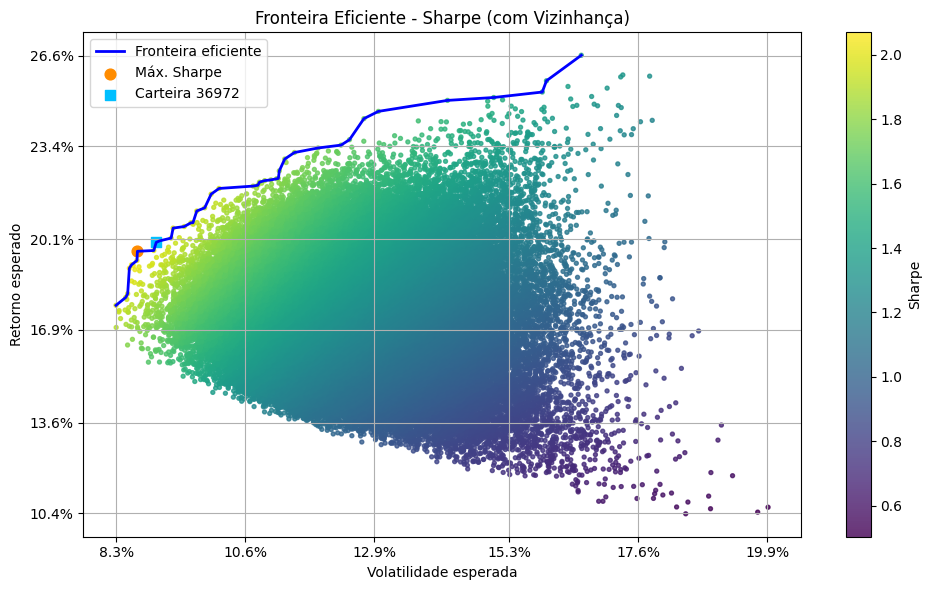

None

In [91]:
# ===============================
# 📉 Gráfico da Fronteira Eficiente
# ===============================

VIZINHO_N = 5

vizinho_sharpe_index = indices_ordenados[-(VIZINHO_N+1)]

grafico_fronteira_eficiente = plot_fronteira_eficiente(
    volatilidades=vetor_volatilidades_esperadas,
    retornos=vetor_retornos_esperados,
    vetor_ordenacao=vetor_sharpe,
    titulo="Fronteira Eficiente - Sharpe (com Vizinhança)",
    label_ordenacao="Sharpe",
    cor_destaque="darkorange",
    idx_vizinho=vizinho_sharpe_index
)


display(grafico_fronteira_eficiente)

## Com Penalização de lambda

In [92]:
# 🔧 Configuração penalização

lambda_penalizacao = 0.4  # Parâmetro que controla o peso da penalização

# ===============================================================================================

numero_carteiras = 100000  # Número total de carteiras simuladas
vetor_retornos_esperados = np.zeros(numero_carteiras)
vetor_volatilidades_esperadas = np.zeros(numero_carteiras)
vetor_sharpe = np.zeros(numero_carteiras)
vetor_sharpe_penalizado = np.zeros(numero_carteiras)  # Novo vetor
tabela_pesos = np.zeros((numero_carteiras, len(tickers_sharpe)))

# Loop com barra de progresso
for k in tqdm(range(numero_carteiras), desc="Simulando carteiras"):
    pesos = np.random.random(len(tickers_sharpe))
    pesos /= np.sum(pesos)  # Normaliza
    tabela_pesos[k, :] = pesos

    # Retorno e volatilidade anualizados
    retorno = np.sum(returns_mean[tickers_sharpe].values * pesos) * 252
    volatilidade = np.sqrt(np.dot(pesos.T, np.dot(matrix_cov.loc[tickers_sharpe, tickers_sharpe] * 252, pesos)))

    vetor_retornos_esperados[k] = retorno
    vetor_volatilidades_esperadas[k] = volatilidade
    vetor_sharpe[k] = retorno / volatilidade

    # Penalidade por concentração (quanto mais concentrado, maior a penalidade)
    penalidade_concentracao = lambda_penalizacao * np.sum(pesos**2)
    vetor_sharpe_penalizado[k] = vetor_sharpe[k] - penalidade_concentracao

Simulando carteiras: 100%|██████████| 100000/100000 [02:29<00:00, 667.52it/s]


In [93]:
np.set_printoptions(suppress=True)  # Desativa notação científica

# ===============================
# 🟢 Carteira com Sharpe Penalizado Máximo
# ===============================

max_sharpe_pen_index = vetor_sharpe_penalizado.argmax()  # Índice da carteira com maior Sharpe penalizado
melhor_carteira_penalizada = tabela_pesos[max_sharpe_pen_index, :]  # Pesos da carteira ótima penalizada

print("🔝 Carteira com maior Índice de Sharpe Penalizado (retorno ajustado à diversificação):\n")

tabela_resultados_pen = pd.DataFrame({
    'Ticker': tickers_sharpe,
    'Peso (%)': [f'{peso*100:.2f}%' for peso in melhor_carteira_penalizada]
})
print(tabela_resultados_pen)

# Retorno esperado aritmético (usando log-retornos)
tabela_retornos_esperados_aritmetica = np.exp(vetor_retornos_esperados) - 1

print(f'\n📈 Retorno esperado (1 ano): {tabela_retornos_esperados_aritmetica[max_sharpe_pen_index]*100:.2f}%')
print(f"📊 Índice de Sharpe penalizado: {vetor_sharpe_penalizado[max_sharpe_pen_index]:.4f}")
print(f"📊 Sharpe sem penalização: {vetor_sharpe[max_sharpe_pen_index]:.4f}")

# ===============================
# 🔍 Carteira "vizinha" — Sharpe Penalizado
# ===============================
VIZINHO_N = 9

print("\n-----------------------------------------------------------------------------------------------------------")
print(f'\n🔄 Carteira {VIZINHO_N} da Vizinhança do Maior Índice de Sharpe Penalizado:')

indices_ordenados_pen = np.argsort(vetor_sharpe_penalizado)
vizinhanca_max_sharpe_index_pen = indices_ordenados_pen[-(VIZINHO_N+1)]
vizinhanca_carteira_pen = tabela_pesos[vizinhanca_max_sharpe_index_pen, :]

tabela_resultados_vizinha_pen = pd.DataFrame({
    'Ticker': tickers_sharpe,
    'Peso (%)': [f'{peso*100:.2f}%' for peso in vizinhanca_carteira_pen]
})
print(tabela_resultados_vizinha_pen)

print(f'\n📈 Retorno esperado (1 ano): {tabela_retornos_esperados_aritmetica[vizinhanca_max_sharpe_index_pen]*100:.2f}%')
print(f"📊 Índice de Sharpe (sem penalização): {vetor_sharpe[vizinhanca_max_sharpe_index_pen]:.4f}")
print(f"📊 Índice de Sharpe penalizado: {vetor_sharpe_penalizado[vizinhanca_max_sharpe_index_pen]:.4f}")


# ===============================
# 🧮 Top carteiras por Sharpe (tabela completa)
# ===============================

print("\n-----------------------------------------------------------------------------------------------------------")
df_top_sharpe_penalizado = mostrar_top_carteiras(
    vetor_ordenacao=vetor_sharpe_penalizado,
    vetor_retornos_esperados=vetor_retornos_esperados,
    tabela_pesos=tabela_pesos,
    tickers=tickers_sharpe,
    top_n=2000,
    nome_ordenacao="Sharpe Penalizado"
)

display(df_top_sharpe_penalizado)

🔝 Carteira com maior Índice de Sharpe Penalizado (retorno ajustado à diversificação):

      Ticker Peso (%)
0   VALE3.SA   12.31%
1   PETR4.SA    3.09%
2   BBSE3.SA   15.98%
3   CMIG4.SA   19.08%
4  SNAG11.SA   48.18%
5   FLRY3.SA    1.36%

📈 Retorno esperado (1 ano): 20.06%
📊 Índice de Sharpe penalizado: 1.8840
📊 Sharpe sem penalização: 2.0082

-----------------------------------------------------------------------------------------------------------

🔄 Carteira 9 da Vizinhança do Maior Índice de Sharpe Penalizado:
      Ticker Peso (%)
0   VALE3.SA    8.88%
1   PETR4.SA   11.50%
2   BBSE3.SA   17.91%
3   CMIG4.SA   14.63%
4  SNAG11.SA   45.53%
5   FLRY3.SA    1.55%

📈 Retorno esperado (1 ano): 19.10%
📊 Índice de Sharpe (sem penalização): 1.9665
📊 Índice de Sharpe penalizado: 1.8536

-----------------------------------------------------------------------------------------------------------

📋 Top 2000 carteiras ordenadas por: Sharpe Penalizado



Retorno Esperado(%) Sharpe Penalizado VALE3.SA PETR4.SA BBSE3.SA  \
0                  20.06            1.8840   12.31%    3.09%   15.98%   
1                  18.81            1.8818   14.23%    6.98%   12.67%   
2                  18.40            1.8761    6.71%    8.13%   14.29%   
3                  18.54            1.8752   10.70%    7.60%   19.49%   
4                  19.95            1.8732   11.80%    1.22%   21.33%   
...                  ...               ...      ...      ...      ...   
1995               19.69            1.5855    0.62%    7.81%   30.74%   
1996               19.68            1.5854   18.15%    8.80%   28.74%   
1997               21.10            1.5854   15.12%   11.00%    5.23%   
1998               19.38            1.5853   10.75%   20.07%   23.88%   
1999               19.07            1.5853    1.88%   20.07%   20.39%   

     CMIG4.SA SNAG11.SA FLRY3.SA  
0      19.08%    48.18%    1.36%  
1      10.24%    53.84%    2.03%  
2       9.95%    56.69%    4.22%  
3       9.84%    50.53%    1.84%  
4      17.74%    47.86%    0.05%  
...       ...       ...      ...  
1995   24.36%    31.78%    4.69%  
1996   20.02%    23.46%    0.83%  
1997   31.21%    31.10%    6.34%  
1998   19.29%    25.71%    0.31%  
1999   20.69%    31.90%    5.07%  

[2000 rows x 8 columns]

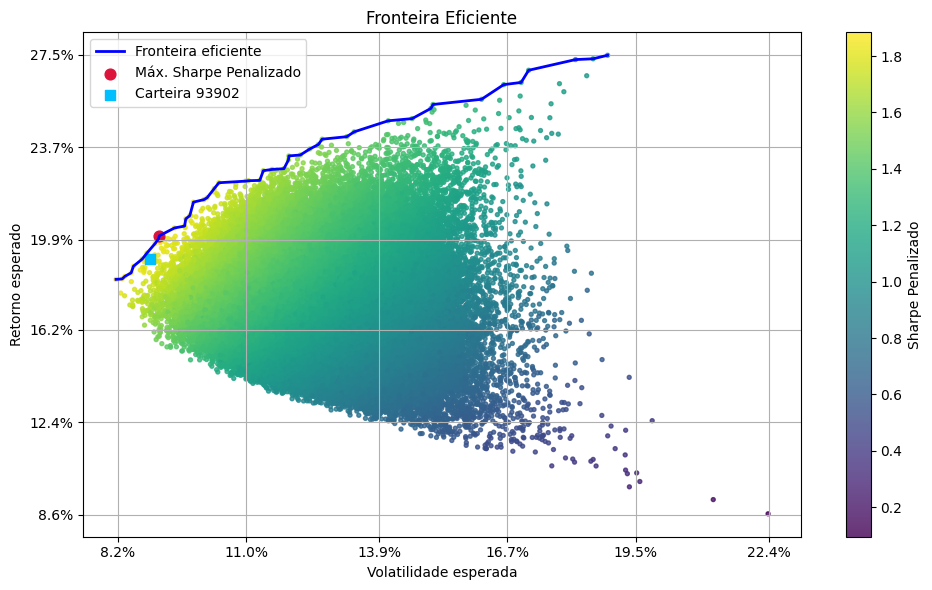

In [94]:
# ===============================
# 📉 Gráfico da Fronteira Eficiente com penalização
# ===============================

VIZINHO_N = 9

indices_ordenados_pen = np.argsort(vetor_sharpe_penalizado)  # ordenar pelo Sharpe penalizado
vizinho_sharpe_index_pen = indices_ordenados_pen[-(VIZINHO_N+1)]

grafico_fronteira_penalizada = plot_fronteira_eficiente(
    volatilidades=vetor_volatilidades_esperadas,
    retornos=vetor_retornos_esperados,
    vetor_ordenacao=vetor_sharpe_penalizado,
    titulo="Fronteira Eficiente",
    label_ordenacao="Sharpe Penalizado",
    cor_destaque="crimson",
    idx_vizinho=vizinho_sharpe_index_pen  # <<< AQUI
)

## Update — Otimização do modelo anterior

📌 **Observações técnicas importantes**

Esta versão corrige as principais limitações do modelo clássico de Markowitz.

A penalização adotada agora:

1. **Não depende do número de ativos**  
2. **Penaliza concentração informacional**, e não de forma arbitrária

In [95]:


# ===============================================================================================
# CONFIGURAÇÕES GERAIS
# ===============================================================================================

numero_carteiras = 100000
lambda_penalizacao = 0.4
rf_anual = 0.13  # Taxa livre de risco anual (ex: Selic aproximada)
epsilon = 1e-8  # Estabilidade numérica

ativos = tickers_sharpe
n_assets = len(ativos)

# ===============================================================================================
# RETORNO ESPERADO ROBUSTO (EWMA)
# ===============================================================================================

returns_assets = returns[ativos]

retornos_esperados = (
    returns_assets
    .ewm(span=60, adjust=False)
    .mean()
    .iloc[-1]
    .values
) * 252

# ===============================================================================================
# MATRIZ DE COVARIÂNCIA COM SHRINKAGE (LEDOIT-WOLF)
# ===============================================================================================

lw = LedoitWolf().fit(returns_assets.dropna())
cov_matrix = lw.covariance_ * 252

# ===============================================================================================
# VETORES DE ARMAZENAMENTO
# ===============================================================================================

vetor_retornos_esperados = np.zeros(numero_carteiras)
vetor_volatilidades_esperadas = np.zeros(numero_carteiras)
vetor_sharpe = np.zeros(numero_carteiras)
vetor_sharpe_penalizado = np.zeros(numero_carteiras)
tabela_pesos = np.zeros((numero_carteiras, n_assets))

# ===============================================================================================
# SIMULAÇÃO DE CARTEIRAS
# ===============================================================================================

for k in tqdm(range(numero_carteiras), desc="Simulando carteiras robustas"):

    # Pesos aleatórios normalizados
    pesos = np.random.random(n_assets)
    pesos /= np.sum(pesos)
    tabela_pesos[k, :] = pesos

    # Retorno esperado da carteira
    retorno = np.dot(retornos_esperados, pesos)

    # Volatilidade esperada da carteira
    volatilidade = np.sqrt(np.dot(pesos.T, np.dot(cov_matrix, pesos)))

    # Sharpe Ratio correto
    sharpe = (retorno - rf_anual) / (volatilidade + epsilon)

    # Penalização por ENTROPIA (concentração real)
    penalidade_entropia = lambda_penalizacao * np.sum(pesos * np.log(pesos + epsilon))

    # Sharpe penalizado
    sharpe_penalizado = sharpe - penalidade_entropia

    # Armazenamento
    vetor_retornos_esperados[k] = retorno
    vetor_volatilidades_esperadas[k] = volatilidade
    vetor_sharpe[k] = sharpe
    vetor_sharpe_penalizado[k] = sharpe_penalizado

# ===============================================================================================
# IDENTIFICAÇÃO DA MELHOR CARTEIRA
# ===============================================================================================

idx_melhor = np.argmax(vetor_sharpe_penalizado)

melhor_pesos = tabela_pesos[idx_melhor]
melhor_sharpe = vetor_sharpe_penalizado[idx_melhor]
melhor_retorno = vetor_retornos_esperados[idx_melhor]
melhor_vol = vetor_volatilidades_esperadas[idx_melhor]

print("===== MELHOR CARTEIRA (ROBUSTA) =====")
print(f"Sharpe Penalizado: {melhor_sharpe:.4f}")
print(f"Retorno Esperado Anual: {melhor_retorno:.2%}")
print(f"Volatilidade Anual: {melhor_vol:.2%}")

print("\nPesos:")
for ativo, peso in zip(ativos, melhor_pesos):
    print(f"{ativo}: {peso:.2%}")


Simulando carteiras robustas: 100%|██████████| 100000/100000 [00:02<00:00, 44784.12it/s]

===== MELHOR CARTEIRA (ROBUSTA) =====
Sharpe Penalizado: 7.2159
Retorno Esperado Anual: 87.90%
Volatilidade Anual: 11.38%

Pesos:
VALE3.SA: 32.45%
PETR4.SA: 15.55%
BBSE3.SA: 7.94%
CMIG4.SA: 4.20%
SNAG11.SA: 29.68%
FLRY3.SA: 10.18%


In [96]:
np.set_printoptions(suppress=True)  # Desativa notação científica

# ===============================
# 🟢 Carteira com Sharpe Penalizado Máximo
# ===============================

max_sharpe_pen_index = vetor_sharpe_penalizado.argmax()  # Índice da carteira com maior Sharpe penalizado
melhor_carteira_penalizada = tabela_pesos[max_sharpe_pen_index, :]  # Pesos da carteira ótima penalizada

print("🔝 Carteira com maior Índice de Sharpe Penalizado (retorno ajustado à diversificação):\n")

tabela_resultados_pen = pd.DataFrame({
    'Ticker': tickers_sharpe,
    'Peso (%)': [f'{peso*100:.2f}%' for peso in melhor_carteira_penalizada]
})
print(tabela_resultados_pen)

# Retorno esperado aritmético (usando log-retornos)
tabela_retornos_esperados_aritmetica = np.exp(vetor_retornos_esperados) - 1

print(f'\n📈 Retorno esperado (1 ano): {tabela_retornos_esperados_aritmetica[max_sharpe_pen_index]*100:.2f}%')
print(f"📊 Índice de Sharpe penalizado: {vetor_sharpe_penalizado[max_sharpe_pen_index]:.4f}")
print(f"📊 Sharpe sem penalização: {vetor_sharpe[max_sharpe_pen_index]:.4f}")


# ===============================
# 🧮 Top carteiras por Sharpe (tabela completa)
# ===============================

print("\n-----------------------------------------------------------------------------------------------------------")
df_top_sharpe_penalizado = mostrar_top_carteiras(
    vetor_ordenacao=vetor_sharpe_penalizado,
    vetor_retornos_esperados=vetor_retornos_esperados,
    tabela_pesos=tabela_pesos,
    tickers=tickers_sharpe,
    top_n=2000,
    nome_ordenacao="Sharpe Penalizado"
)

display(df_top_sharpe_penalizado)

🔝 Carteira com maior Índice de Sharpe Penalizado (retorno ajustado à diversificação):

      Ticker Peso (%)
0   VALE3.SA   32.45%
1   PETR4.SA   15.55%
2   BBSE3.SA    7.94%
3   CMIG4.SA    4.20%
4  SNAG11.SA   29.68%
5   FLRY3.SA   10.18%

📈 Retorno esperado (1 ano): 140.85%
📊 Índice de Sharpe penalizado: 7.2159
📊 Sharpe sem penalização: 6.5831

-----------------------------------------------------------------------------------------------------------

📋 Top 2000 carteiras ordenadas por: Sharpe Penalizado



Retorno Esperado(%) Sharpe Penalizado VALE3.SA PETR4.SA BBSE3.SA  \
0                 140.85            7.2159   32.45%   15.55%    7.94%   
1                 143.03            7.2157   33.11%   15.40%    7.62%   
2                 149.78            7.2124   37.17%   16.63%   10.13%   
3                 149.99            7.2109   35.95%   15.96%    6.37%   
4                 134.36            7.2092   31.22%   14.91%   11.41%   
...                  ...               ...      ...      ...      ...   
1995              120.85            6.9364   29.10%   12.51%   11.73%   
1996              142.29            6.9364   32.86%   14.70%   17.58%   
1997              139.54            6.9363   26.80%   25.62%    0.36%   
1998              135.54            6.9363   30.05%   19.15%   24.12%   
1999              137.90            6.9361   27.24%   27.74%    8.15%   

     CMIG4.SA SNAG11.SA FLRY3.SA  
0       4.20%    29.68%   10.18%  
1       3.36%    29.40%   11.11%  
2       3.41%    26.61%    6.06%  
3       0.86%    29.87%   11.00%  
4       4.33%    30.76%    7.37%  
...       ...       ...      ...  
1995   10.88%    35.52%    0.26%  
1996   11.52%    14.98%    8.35%  
1997    6.25%    31.30%    9.66%  
1998    3.86%    18.25%    4.58%  
1999    5.55%    27.47%    3.85%  

[2000 rows x 8 columns]

In [97]:
df_top_sharpe_penalizado['Sharpe Penalizado'] = df_top_sharpe_penalizado['Sharpe Penalizado'].astype('Float64').round(2)
df_top_sharpe_penalizado['Retorno Esperado(%)'] = df_top_sharpe_penalizado['Retorno Esperado(%)'].astype('Float64').round(2)


In [98]:
df_top_sharpe_penalizado.sort_values(by = ['Sharpe Penalizado','Retorno Esperado(%)'], ascending = False)

Retorno Esperado(%)  Sharpe Penalizado VALE3.SA PETR4.SA BBSE3.SA  \
1                  143.03               7.22   33.11%   15.40%    7.62%   
0                  140.85               7.22   32.45%   15.55%    7.94%   
3                  149.99               7.21   35.95%   15.96%    6.37%   
2                  149.78               7.21   37.17%   16.63%   10.13%   
7                  143.66               7.21   33.83%   18.00%   13.00%   
...                   ...                ...      ...      ...      ...   
1986               118.59               6.94   26.84%   16.71%   17.04%   
1956               116.12               6.94   24.15%   15.58%   21.52%   
1938               114.24               6.94   22.56%   16.10%    7.58%   
1916               113.47               6.94   22.62%   13.27%   15.14%   
1981               112.63               6.94   19.80%   18.01%   13.59%   

     CMIG4.SA SNAG11.SA FLRY3.SA  
1       3.36%    29.40%   11.11%  
0       4.20%    29.68%   10.18%  
3       0.86%    29.87%   11.00%  
2       3.41%    26.61%    6.06%  
7       1.37%    27.00%    6.80%  
...       ...       ...      ...  
1986    0.21%    38.74%    0.46%  
1956    3.23%    31.45%    4.08%  
1938    8.98%    39.70%    5.08%  
1916    8.70%    33.42%    6.84%  
1981    2.81%    37.36%    8.44%  

[2000 rows x 8 columns]

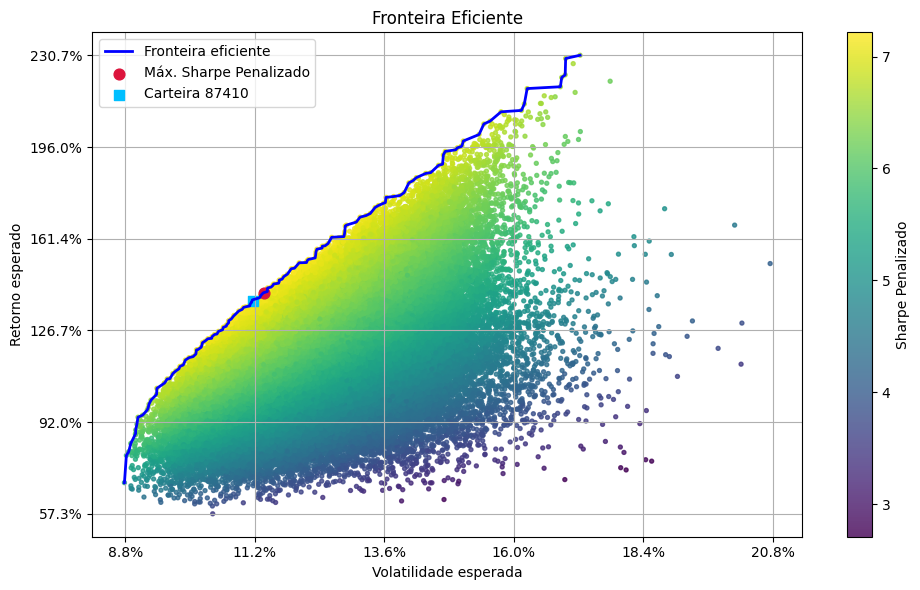

In [99]:
# ===============================
# 📉 Gráfico da Fronteira Eficiente com penalização
# ===============================

VIZINHO_N = 9

indices_ordenados_pen = np.argsort(vetor_sharpe_penalizado)  # ordenar pelo Sharpe penalizado
vizinho_sharpe_index_pen = indices_ordenados_pen[-(VIZINHO_N+1)]

grafico_fronteira_penalizada = plot_fronteira_eficiente(
    volatilidades=vetor_volatilidades_esperadas,
    retornos=vetor_retornos_esperados,
    vetor_ordenacao=vetor_sharpe_penalizado,
    titulo="Fronteira Eficiente",
    label_ordenacao="Sharpe Penalizado",
    cor_destaque="crimson",
    idx_vizinho=vizinho_sharpe_index_pen
)

## Monte Carlo

In [100]:
from numpy import linalg as LA

# Criação do modelo base
df_prices = prices.drop(columns = ['^BVSP','Dolar','Selic', 'IPCA','Month'])
df_prices = df_prices.set_index('Date')

retorno = df_prices.pct_change().dropna()
media_retorno = retorno.mean()

matriz_covariance = retorno.cov()
numeros_ativos = len(df_prices.columns)
pesos_carteira = [0.3453, 0.1571,0.0724, 0.0342, 0.3020, 0.089]


#Variaveis de simulação
numero_simulacao = 10000
dias_projetados = 252
capital_inicial = 50000

#Resultados
retorno_medio = retorno.mean(axis = 0).to_numpy()
matriz_retorno_medio = retorno_medio * np.ones( shape = (dias_projetados, numeros_ativos))


/tmp/ipython-input-271/1173998685.py:7: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  retorno = df_prices.pct_change().dropna()


In [101]:
L = LA.cholesky(matriz_covariance)

retornos_carteira = np.zeros([dias_projetados, numero_simulacao])
montante_final = np.zeros(numero_simulacao)

for s in range (numero_simulacao):
    Rpdf = np.random.normal(size=(dias_projetados, numeros_ativos))

    retornos_sinteticos = matriz_retorno_medio + np.inner(Rpdf, L)

    retornos_carteira[:,s] = np.cumprod(np.inner(pesos_carteira, retornos_sinteticos + 1)) * capital_inicial

    montante_final[s] = retornos_carteira[-1,s]

retornos_carteira


array([[50211.14110213, 49444.63325016, 49790.53267139, ...,
        50209.01878203, 50345.63951456, 49667.48639177],
       [49900.91937359, 49614.31082283, 49520.30306894, ...,
        50586.66816848, 49992.95949116, 49037.86567981],
       [49790.01832652, 49161.06998522, 48498.42114943, ...,
        50402.87927089, 50316.76555621, 49239.66548408],
       ...,
       [66025.04567437, 59409.23035168, 59477.54123768, ...,
        62772.05881705, 68645.70317493, 57144.19113405],
       [66173.21950353, 58987.7430193 , 59462.29582209, ...,
        62941.53841418, 69142.6513297 , 57404.51576046],
       [65901.77973087, 58750.9102714 , 59864.37597612, ...,
        63323.23811265, 69221.09849039, 57304.0214918 ]])

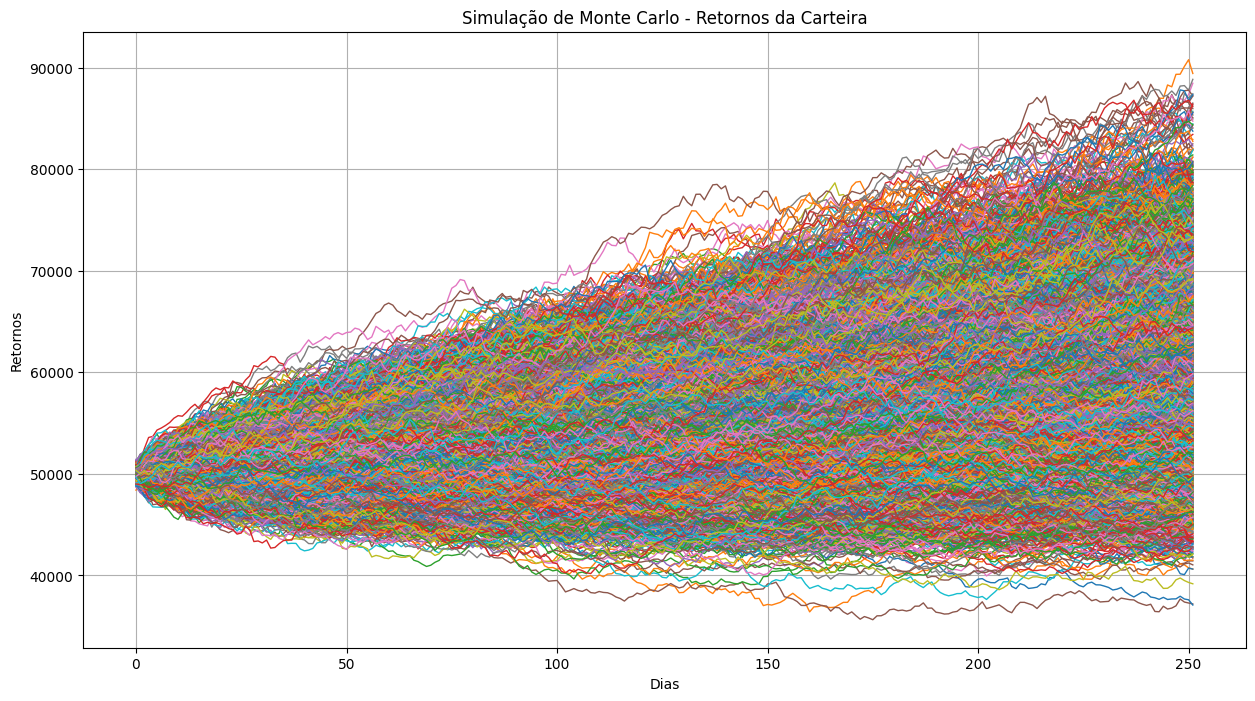

In [102]:
plt.subplots(figsize = (15,8))
plt.plot(retornos_carteira, linewidth=1)
plt.title('Simulação de Monte Carlo - Retornos da Carteira')
plt.xlabel('Dias')
plt.ylabel('Retornos')
plt.grid()
plt.show()

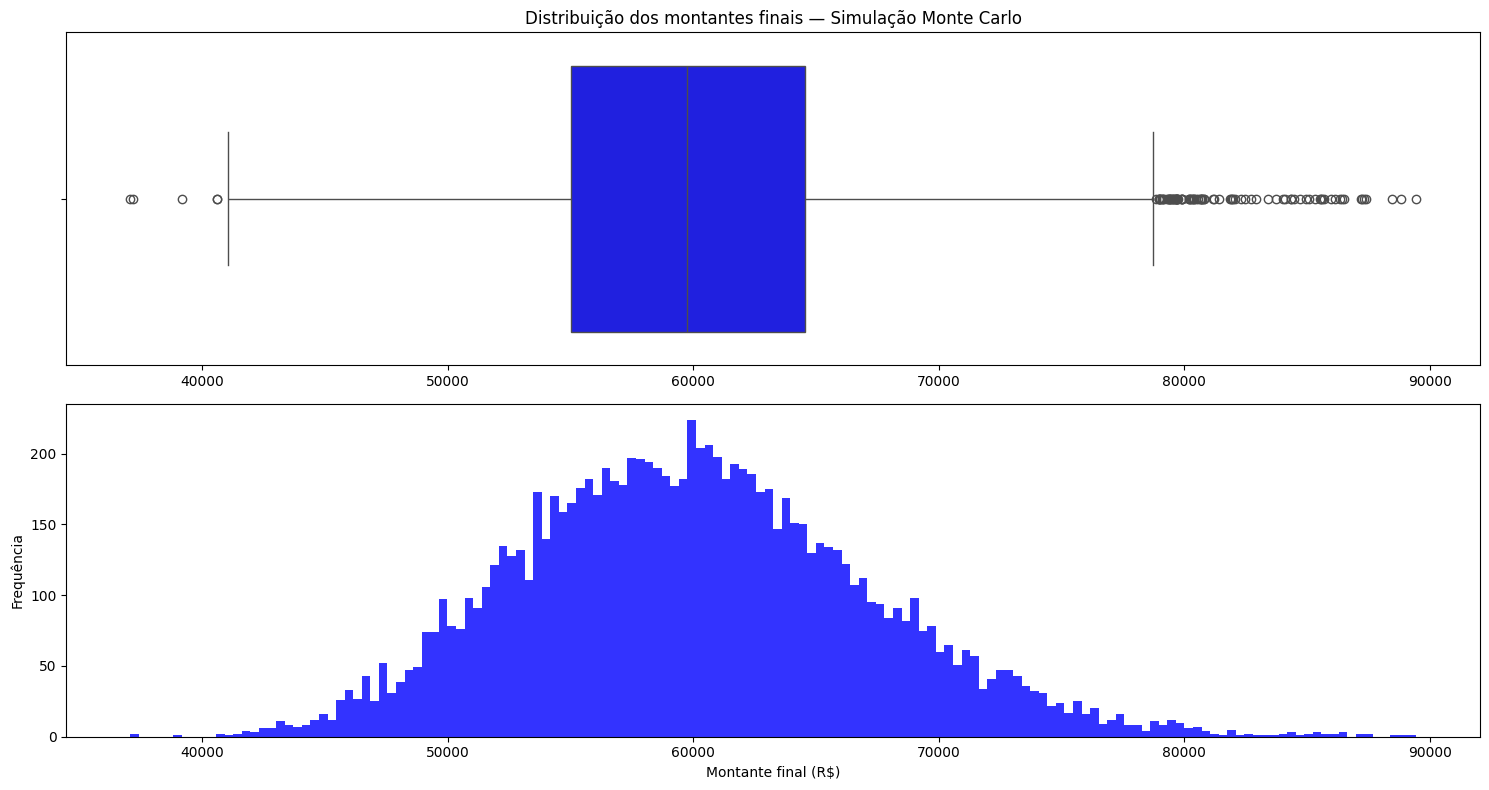

In [103]:
plt.style.use("default")
# ================================
# Configurações do histograma
# ================================
config = dict(
    histtype="stepfilled",
    alpha=0.8,
    density=False,
    bins=150,
    color='blue'
)

# ================================
# Criação da figura e subplots
# ================================
fig, axes = plt.subplots(2, 1, figsize=(15, 8))


# ================================
# Boxplot — Montante final
# ================================
sns.boxplot(x=montante_final, ax=axes[0], color='blue')
axes[0].set_title('Distribuição dos montantes finais — Simulação Monte Carlo')


# ================================
# Histograma — Montante final
# ================================
axes[1].hist(montante_final, **config)
axes[1].set_xlabel('Montante final (R$)')
axes[1].set_ylabel('Frequência')

# ================================
# Ajustes finais
# ================================
plt.tight_layout()
plt.show()